#MNIST

Este notebook foi baseado no capítulo 3 do livro do Aurélien Geron, e no [notebook](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb) dele e do [professor](https://github.com/edsonjunior14/mlcourse/blob/master/MNIST_classification.ipynb) Edson Júnior.


MNIST é um conjunto de dados com 70 000 instâncias, cada uma delas representando uma foto de um digíto escrito à mão. Cada foto contém 784 features que indicam a intensidade de cor preto-branco de cada pixel em uma imagem de 28x28 pixels. 






# 1. IMPORTAR E PLOTAR OS DADOS

In [1]:
# biblotecas 
import numpy as np
import pandas as pd 
import os


# Para reproduzir o experimento
np.random.seed(42)

# Plotar figura
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Salvar imagens
def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id, format='png', dpi=600)

In [2]:
#importando os dados 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) 

In [3]:
# tipo de dado
type(mnist)

sklearn.utils.Bunch

Os dados são tais que a chave "data" contém uma matriz com uma linha por instância e uma coluna por feature. E a chave "target" contém uma matriz coluna com os rótulos. 



In [4]:
# instanciando as features
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Agora vamos utilizar o "plt" do matplotlib para realizar o método de interpolação. Nele, são preenchidos os pixels que faltam quando redimensionamos a imagem para 28x28. Abaixo, é utilizada apenas a instância 23000 para ilustrar este fato.

Saving figure some_digit_plot


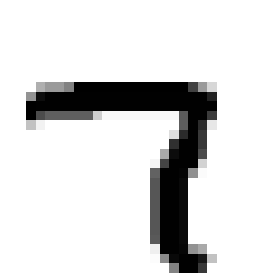

In [5]:
some_digit = X[23000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, 
           cmap = mpl.cm.binary,
           interpolation= 'nearest')

plt.axis("off") 

save_fig("some_digit_plot")
plt.show()

In [6]:
y[23000]

7

Agora vamos fazer o plot com interpolação em TODAS as instâncias:

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# 2. SEPARANDO EM TESTE E TREINO



Vamos utilizar 60000 imagens para treino:

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
#Embaralhando os dados 
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Além de redimensionar as imagens como fizemos antes, podemos aumentar o nosso conjunto de treinamento (**data augmentation**) com as translações das imagems, e isso pode aumentar a performance. Façamos isso:

In [10]:
# importando biblioteca para realizar o deslocamento. 
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28)) #redimensionando
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant") #pontos fora do contorno são postos como zero.
    return shifted_image.reshape([-1])


Vamos testar em uma instância específica:

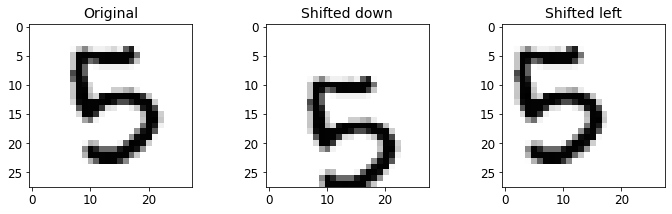

In [11]:
# visualizando em um exemplo
image = X_train[29000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [12]:
# aplicando as translações em todo o conjunto de treino
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)


In [13]:
# embaralhando novamente as instâncias
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

# 3. CLASSIFICAÇÃO MULTICLASSE

In [15]:
from sklearn.linear_model import SGDClassifier # Para usar o gradiente descendente estotástico.
from sklearn.model_selection import GridSearchCV #encontrar melhores parâmetros
from sklearn.pipeline import Pipeline # criar um pipeline!
from sklearn.preprocessing import StandardScaler # escalonar os dados

pipe = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ]) 

# A otimização é feita atravé dos parâmetros loss e alpha

param_grid = [{'estimator__loss' : ['hinge', 'log'],
               'estimator__alpha': [1e-4, 1e-2, 1],
               }] 

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train_augmented, y_train_augmented)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std_scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('estimator',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                  

Vamos olhar para os resultados da otimização:

In [16]:
results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
                     pd.DataFrame(grid_search.cv_results_['std_test_score'], 
                                  columns=["Std"]),
                     pd.DataFrame(grid_search.cv_results_["mean_test_score"], 
                                  columns=["Score"])],axis=1)

results.sort_values("Score", ascending=False) 
#Ordenamento decrescente
# O score é herdado do estimador, nesse caso a acurácia.

,estimator__alpha,estimator__loss,Std,Score
0,0.0001,hinge,0.002324,0.876340
1,0.0001,log,0.001351,0.875453
2,0.0100,hinge,0.001533,0.860883
3,0.0100,log,0.001434,0.859877
4,1.0000,hinge,0.004201,0.821080
5,1.0000,log,0.005498,0.795503


Agora treinamos o modelo com os melhores parâmetros encontrados no GridSearch:

In [17]:
model = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 10, random_state=42))
             ])

model.set_params(**grid_search.best_params_) #Introduz no pipeline os parametros



Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=10, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [18]:
model.fit(X_train_augmented, y_train_augmented) #treinando o modelo com OvR (one versus rest)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=10, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [19]:
# predizendo uma instância de teste
some_digit = X_test[0]
model.predict([some_digit])

array([7], dtype=int8)

In [20]:
# vendo o rótulo 
y_test[0]

7

Agora usaremos o esquema OvO no SGD. 

In [21]:
# Força a implementação OvO.
from sklearn.multiclass import OneVsOneClassifier

model = Pipeline([('std_scaler', StandardScaler()),
                 ('estimator', SGDClassifier(max_iter = 1000, random_state=42))
             ])

model.set_params(**grid_search.best_params_)
ovo_clf = OneVsOneClassifier(model)

In [24]:
# testando na mesma instância de antes:
ovo_clf.fit(X_train_augmented, y_train_augmented)
ovo_clf.predict([some_digit])
# mesmo resultado!

array([7], dtype=int8)

Agora algumas métricas para avaliar o modelo:


In [25]:
from sklearn.metrics  import confusion_matrix
y_pred = ovo_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[ 966,    0,    0,    2,    1,    5,    4,    0,    2,    0],
       [   0, 1125,    4,    1,    0,    1,    2,    0,    2,    0],
       [   9,    4,  949,   19,   14,    1,    9,    8,   18,    1],
       [   5,    4,    8,  927,    2,   21,    0,   13,   27,    3],
       [   1,    1,    9,    3,  939,    0,    4,    3,    1,   21],
       [   8,    4,    9,   45,    4,  786,    7,    3,   16,   10],
       [  11,    3,    7,    0,    5,   12,  917,    1,    2,    0],
       [   1,    4,   16,    7,   10,    0,    0,  968,    1,   21],
       [   5,    5,    9,   26,    7,   24,    4,    8,  875,   11],
       [   4,   10,    2,   10,   32,    1,    0,   25,    9,  916]])

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9368

Em comparação com o cálculo feito sem transladar as imagens (disponível [aqui](https://github.com/edsonjunior14/mlcourse/blob/master/MNIST_classification.ipynb) ), o aumento na acurácia foi de 1,23%.